# 导入库

In [1]:
from __future__ import absolute_import
import bottleneck as bn
import tushare as ts
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math, time, datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import bottleneck as bn
import joblib
import requests
import json
import seaborn as sns
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm, trange
from concurrent.futures import ThreadPoolExecutor, wait, ALL_COMPLETED, FIRST_COMPLETED

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

## Tushare配置

In [2]:
ts_token = ""
ts.set_token(ts_token)
pro = ts.pro_api()

# 数据准备

## 股票列表

In [3]:
stock_basic_df = pro.stock_basic()
display(stock_basic_df)

,ts_code,symbol,name,area,industry,market,list_date
0,000001.SZ,000001,平安银行,深圳,银行,主板,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,主板,19910129
2,000004.SZ,000004,国华网安,深圳,互联网,主板,19910114
3,000005.SZ,000005,世纪星源,深圳,环境保护,主板,19901210
4,000006.SZ,000006,深振业A,深圳,区域地产,主板,19920427
5,000007.SZ,000007,全新好,深圳,酒店餐饮,主板,19920413
6,000008.SZ,000008,神州高铁,北京,运输设备,主板,19920507
7,000009.SZ,000009,中国宝安,深圳,综合类,主板,19910625
8,000010.SZ,000010,美丽生态,深圳,建筑工程,主板,19951027
9,000011.SZ,000011,深物业A,深圳,区域地产,主板,19920330


## 基金列表

In [4]:
if os.path.exists('fund_basic_df.joblib'):
    fund_basic_df = joblib.load('fund_basic_df.joblib')
else:
    # 场外基金
    fund_basic_df_0 = pro.fund_basic(market='O')
    fund_basic_df_1 = pro.fund_basic(market='O', offset=10000)
    fund_basic_df = pd.concat([fund_basic_df_0, fund_basic_df_1], axis=0)

    joblib.dump(fund_basic_df, 'fund_basic_df.joblib', protocol=4)
    
display(fund_basic_df.head())
display(fund_basic_df.shape)

,ts_code,name,management,custodian,fund_type,found_date,due_date,list_date,issue_date,delist_date,issue_amount,m_fee,c_fee,duration_year,p_value,min_amount,exp_return,benchmark,status,invest_type,type,trustee,purc_startdate,redm_startdate,market
0,531030.OF,建信周盈安心理财B,建信基金,交通银行,债券型,20201231,None,None,20201231,None,NaN,0.27,0.08,None,1.0,NaN,None,七天通知存款利率(税前),L,债券型,契约型开放式,None,20201231,20201231,O
1,530030.OF,建信周盈安心理财A,建信基金,交通银行,债券型,20201231,None,None,20201231,None,NaN,0.27,0.08,None,1.0,NaN,None,七天通知存款利率(税前),L,债券型,契约型开放式,None,20201231,20201231,O
2,010963.OF,信达澳银周期动力,信达澳银基金,中国工商银行,混合型,20201230,None,None,20201215,None,5.6458,1.50,0.25,None,1.0,0.0010,None,中证资源优选指数收益率*45%+中证先进制造100策略指数收益率*45%+中证港股通综合指数*5%+银行活期存款利率(税后)*5%,L,混合型,契约型开放式,None,None,None,O
3,010874.OF,泰康品质生活A,泰康资产,招商银行,混合型,20201230,None,None,20201221,None,2.6043,1.50,0.25,None,1.0,0.0010,None,沪深300指数收益率*70%+中债新综合全价(总值)指数收益率*15%+恒生指数收益率*10%+金融机构人民币活期存款利率(税后)*5%,L,混合型,契约型开放式,None,None,None,O
4,011000.OF,兴华瑞丰C,兴华基金,招商证券,混合型,20201230,None,None,20201214,None,2.0069,0.60,0.20,None,1.0,0.0001,None,中债国债总全价指数收益率*85%+沪深300指数收益率*15%,L,混合型,契约型开放式,None,None,None,O


(12305, 25)

In [5]:
np.unique(fund_basic_df['invest_type'])

array(['价值型', '价值增长型', '优化增强型', '优选增长型', '优选稳健型', '保本增值型', '保本混合型', '债券型',
       '债券型基金', '偏股混合型', '偏股混合型基金', '创新型', '原油主题基金', '增值型', '增利型',
       '增强债券型', '增强回报型', '增强型', '增强指数型', '增强收益型', '增长型', '平稳型', '平衡型',
       '强化收益型', '成长型', '成长收益复合型', '收益型', '普通股票型', '有色金属期货型', '混合型',
       '灵活配置', '灵活配置型', '积极型', '积极成长型', '积极配置型', '稳健型', '稳健增长型', '稳定型',
       '稳定增值型', '股债配置型', '股票型', '被动指数型', '豆粕期货型', '货币型', '黄金现货合约'],
      dtype=object)

### 从海通里选择3星及以上的基金

In [6]:
ht_grade_df = pd.read_csv('精选三五星.csv')
ht_grade_df.columns = ['fund_code', 'fund_name', 'year_3_star', 'year_5_star']
display(ht_grade_df.head())
display(ht_grade_df.shape)

,fund_code,fund_name,year_3_star,year_5_star
0,110022.OF,易方达消费行业,★★★★★,★★★★
1,070018.OF,嘉实回报灵活配置,★★★★★,★★★★★
2,001171.OF,工银瑞信养老产业,★★★★★,★★★★★
3,260109.OF,景顺长城内需增长贰号,★★★★★,★★★★
4,260108.OF,景顺长城新兴成长,★★★★★,★★★★★


(430, 4)

In [7]:
# 字段含义
# name	str	Y	简称
# management	str	Y	管理人
# custodian	str	Y	托管人
# fund_type	str	Y	投资类型
# found_date	str	Y	成立日期
# due_date	str	Y	到期日期
# list_date	str	Y	上市时间
# issue_date	str	Y	发行日期
# delist_date	str	Y	退市日期
# issue_amount	float	Y	发行份额(亿)
# m_fee	float	Y	管理费
# c_fee	float	Y	托管费
# duration_year	float	Y	存续期
# p_value	float	Y	面值
# min_amount	float	Y	起点金额(万元)
# exp_return	float	Y	预期收益率
# benchmark	str	Y	业绩比较基准
# status	str	Y	存续状态D摘牌 I发行 L已上市
# invest_type	str	Y	投资风格
# type	str	Y	基金类型
# trustee	str	Y	受托人
# purc_startdate	str	Y	日常申购起始日
# redm_startdate	str	Y	日常赎回起始日
# market	str	Y	E场内O场外

'''
# 老方法: 
# 偏股混合型, 偏股混合型基金, 增强回报型, 增强指数型, 增强收益型, 普通股票型, 灵活配置, 灵活配置型
# 过滤股票型基金
stock_fund_df = fund_basic_df[(fund_basic_df['invest_type'] == '股票型') | (fund_basic_df['invest_type'] == '偏股混合型') | (fund_basic_df['invest_type'] == '偏股混合型基金') | (fund_basic_df['invest_type'] == '增强回报型') | (fund_basic_df['invest_type'] == '增强指数型') | (fund_basic_df['invest_type'] == '增强收益型') | (fund_basic_df['invest_type'] == '普通股票型') | (fund_basic_df['invest_type'] == '灵活配置') | (fund_basic_df['invest_type'] == '灵活配置型')]
'''

'''
新方法:
按照海通3星以上选择
'''
stock_fund_df = fund_basic_df[fund_basic_df['ts_code'].isin(list(ht_grade_df['fund_code']))]

display(stock_fund_df.head())
display(stock_fund_df.shape)

,ts_code,name,management,custodian,fund_type,found_date,due_date,list_date,issue_date,delist_date,issue_amount,m_fee,c_fee,duration_year,p_value,min_amount,exp_return,benchmark,status,invest_type,type,trustee,purc_startdate,redm_startdate,market
9032,001473.OF,建信大安全,建信基金,中信证券,股票型,20150729,None,None,20150629,None,2.6191,1.5,0.25,None,1.0,0.001,None,沪深300指数收益率*85%+中债总财富(总值)指数收益率*15%,L,股票型,契约型开放式,None,20150828,20150828,O
9035,001577.OF,嘉实低价策略,嘉实基金,中国建设银行,股票型,20150727,None,None,20150701,None,7.4646,1.5,0.25,None,1.0,0.100,None,沪深300指数收益率*80%+中证综合债券指数收益率*20%,L,股票型,契约型开放式,None,20150928,20150928,O
9073,001490.OF,汇添富国企创新增长,汇添富基金,中国工商银行,股票型,20150710,None,None,20150701,None,31.0441,1.5,0.25,None,1.0,0.100,None,中证国有企业综合指数*80%+中债综合指数*20%,L,股票型,契约型开放式,None,20150930,20150930,O
9076,001538.OF,上投摩根科技前沿,上投摩根基金,中国银行,混合型,20150709,None,None,20150701,None,2.6104,1.5,0.25,None,1.0,0.100,None,中证800指数收益率*60%+中债总指数收益率*40%,L,灵活配置型,契约型开放式,None,20150810,20150810,O
9086,001365.OF,大成正向回报,大成基金,中国农业银行,混合型,20150708,None,None,20150615,None,3.6874,1.5,0.25,None,1.0,0.100,None,一年期银行定期存款利率+2%,L,灵活配置型,契约型开放式,None,20150806,20150806,O


(404, 25)

## 基金净值

In [8]:
fund_codes = list(stock_fund_df['ts_code'])
fund_nav_dict_file = f'fund_nav_dict_{len(fund_codes)}.joblib'

if os.path.exists(fund_nav_dict_file):
    fund_nav_dict = joblib.load(fund_nav_dict_file)
else:
    # 多线程获取基金净值
    all_task = []
    executor = ThreadPoolExecutor(max_workers=16)
    pbar = tqdm(total=len(fund_codes))

    fund_nav_dict = {}
    
    # 获取某个基金的净值
    def get_fund_nav(pbar, fund_code):
        while True:
            try:
                fund_nav_part = pro.fund_nav(ts_code=fund_code, market='O').drop_duplicates()
                fund_nav_dict[fund_code] = fund_nav_part
            except Exception as e:
                if ('抱歉，您每分钟最多访问该接口' in str(e)) or ('Max retries exceeded with url' in str(e)):
                    time.sleep(5)
                    continue
                    
                print(e)
            
            break
        
        pbar.update(1)

    for fund_code in fund_codes:
        all_task.append(executor.submit(get_fund_nav, pbar, fund_code))
#         get_fund_nav(pbar, fund_code)

    wait(all_task, return_when=ALL_COMPLETED)
    joblib.dump(fund_nav_dict, fund_nav_dict_file, protocol=4)
    
# 字段含义
# ts_code	str	Y	TS代码
# ann_date	str	Y	公告日期
# end_date	str	Y	截止日期
# unit_nav	float	Y	单位净值
# accum_nav	float	Y	累计净值
# accum_div	float	Y	累计分红
# net_asset	float	Y	资产净值
# total_netasset	float	Y	合计资产净值
# adj_nav	float	Y	复权单位净值

display(len(fund_nav_dict.keys()))

404

## 基金经理

In [9]:
if os.path.exists('fund_manager_df.joblib'):
    fund_manager_df = joblib.load('fund_manager_df.joblib')
else:
    fund_manager_df = pd.DataFrame()
    offset = 0
    limit = 5000

    # 遍历分页获取
    while True:
        fund_manager_df_part = pro.fund_manager(offset=offset, limit=limit)
        
        # 如果取不到数据了（0）维(rows)长度为 0
        if fund_manager_df_part.shape[0] == 0:
            break

        offset += limit
        print(offset)
        fund_manager_df = pd.concat([fund_manager_df, fund_manager_df_part], axis=0)
        
    joblib.dump(fund_manager_df, 'fund_manager_df.joblib', protocol=4)
    
display(fund_manager_df.head(5))

,ts_code,ann_date,name,gender,birth_year,edu,nationality,begin_date,end_date,resume
0,000001.OF,20140621,童汀,M,None,硕士,中国,20100116,20140620,中国人民银行总行研究生部经济学硕士。曾任南方基金管理有限公司基金经理助理、策略研究员、行业研究员。2007年加入华夏基金管理有限公司，历任兴和证券投资基金基金经理(2007年4月18日至2009年1月1日期间)、华夏复兴股票型证券投资基金基金经理(2007年9月10日至2009年1月1日期间)、华夏红利混合型证券投资基金基金经理(2009年1月1日至2010年1月16日期间)、华夏成长证券投资基金基金经理(2010年1月16日至2014年6月20日期间)。
1,000001.OF,20150109,董阳阳,M,None,硕士,中国,20150107,None,美国波士顿学院金融学硕士、工商管理学硕士。2008年7月至2009年8月，曾任中国国际金融有限公司投行业务部经理，2009年8月加入华夏基金管理有限公司，曾任研究员、基金经理助理、投资经理等。2013年3月11日至2017年2月24日担任华夏蓝筹核心混合型证券投资基金(LOF)基金经理，2015年1月7日起任华夏成长证券投资基金基金经理。2016年12月起至2020年5月任华夏圆和灵活配置混合型证券投资基金基金经理。2017年9月起任华夏新机遇灵活配置混合型证券投资基金基金经理。2018年1月起任华夏磐晟定期开放灵活配置混合型证券投资基金(LOF)基金经理(2018年12月转型为华夏磐晟灵活配置混合型证券投资基金(LOF))。2018年6月起至2020年5月任华夏鼎沛债券型证券投资基金基金经理。2018年8月至2020年6月任华夏产业升级混合型证券投资基金基金经理。2020年6月起担任华夏鼎利债券型发起式证券投资基金基金经理。
2,000001.OF,20100116,巩怀志,M,None,硕士,中国,20051029,20100116,清华大学MBA。2002年4月加入鹏华基金管理有限公司，曾任基金经理助理、社保股票组合基金经理等。2005年7月加入华夏基金管理有限公司，曾任华夏蓝筹核心混合型证券投资基金(LOF)基金经理(2007年5月9日至2009年1月1日期间)、华夏成长证券投资基金基金经理(2005年10月29日至2010年1月16日期间)等。
3,000001.OF,20170225,孙萌,M,None,硕士,中国,20151119,20170224,2007年6月至2009年4月，曾任长盛基金管理有限公司研究员。2009年4月加入华夏基金管理有限公司，曾任研究员、基金经理助理等。2015年11月至2017年2月担任华夏成长证券投资基金基金经理。2017年2月至2018年7月担任华夏红利混合型证券投资基金基金经理。2018年1月至2019年3月任华夏高端制造灵活配置混合型证券投资基金基金经理。
4,000001.OF,20150109,崔同魁,M,None,硕士,中国,20140620,20150107,清华大学工学硕士，2008年7月加入华夏基金管理有限公司，曾任行业研究员、基金经理助理等。2014年6月20日至2015年1月7日任华夏成长证券投资基金基金经理。2012年7月16日至2015年1月7日任华夏复兴股票型证券投资基金基金经理。


## 基金持仓

In [10]:
fund_portfolio_dict = {}
fund_portfolio_dict_file = f'fund_portfolio_dict_{len(fund_codes)}.joblib'

if os.path.exists(fund_portfolio_dict_file):
    fund_portfolio_dict = joblib.load(fund_portfolio_dict_file)
else:
    # 多线程获取基金持仓
    all_task = []
    executor = ThreadPoolExecutor(max_workers=16)
    pbar = tqdm(total=len(fund_codes))

    fund_portfolio_dict = {}
    
    # 获取某个基金的净值
    def get_fund_portfolio(pbar, fund_code):
        while True:
            try:
                fund_portfolio_part = pro.fund_portfolio(ts_code=fund_code).drop_duplicates(subset=['ts_code', 'ann_date', 'symbol', 'amount']).drop_duplicates(subset=['ts_code', 'ann_date', 'symbol', 'mkv'])
                fund_portfolio_dict[fund_code] = fund_portfolio_part
            except Exception as e:
                if ('抱歉，您每分钟最多访问该接口' in str(e)) or ('Max retries exceeded with url' in str(e)):
                    time.sleep(5)
                    continue
                    
                print(e)
            
            break
        
        pbar.update(1)

    for fund_code in fund_codes:
        all_task.append(executor.submit(get_fund_portfolio, pbar, fund_code))
#         get_fund_nav(pbar, fund_code)

    wait(all_task, return_when=ALL_COMPLETED)        
    joblib.dump(fund_portfolio_dict, fund_portfolio_dict_file, protocol=4)
    
# 字段含义
# ann_date	str	Y	公告日期
# end_date	str	Y	截止日期
# symbol	str	Y	股票代码
# mkv	float	Y	持有股票市值(元)
# amount	float	Y	持有股票数量（股）
# stk_mkv_ratio	float	Y	占股票市值比
# stk_float_ratio	float	Y	占流通股本比例
display(len(fund_portfolio_dict.keys()))

404

## SW行业分类

In [11]:
if os.path.exists('index_classify_df.joblib'):
    index_classify_df = joblib.load('index_classify_df.joblib')
else:
    index_classify_df = pro.index_classify()
    joblib.dump(index_classify_df, 'index_classify_df.joblib', protocol=4)

display(index_classify_df)

,index_code,industry_name,level
0,801020.SI,采掘,L1
1,801030.SI,化工,L1
2,801040.SI,钢铁,L1
3,801050.SI,有色金属,L1
4,801710.SI,建筑材料,L1
5,801720.SI,建筑装饰,L1
6,801730.SI,电气设备,L1
7,801890.SI,机械设备,L1
8,801740.SI,国防军工,L1
9,801880.SI,汽车,L1


## SW行业成本股

In [12]:
if os.path.exists('index_member_df.joblib'):
    index_member_df = joblib.load('index_member_df.joblib')
else:
    index_member_df = pd.DataFrame()
    
    offset = 0
    limit = 2000
    while True:
        index_member_df_part = pro.index_member(offset=offset, limit=limit)
        if index_member_df_part.shape[0] == 0:
            break
        
        offset += limit
        print(offset)
        index_member_df = pd.concat([index_member_df, index_member_df_part], axis=0)

    joblib.dump(index_member_df, 'index_member_df.joblib', protocol=4)
        
# L1/L2/L3，深度，股池会重复，所以选出来27000多条
display(index_member_df)

,index_code,con_code,in_date,out_date
0,801813.SI,600416.SH,20120104,None
1,801813.SI,601636.SH,20120104,None
2,801831.SI,002095.SZ,20120104,None
3,801250.SI,601222.SH,20110815,None
4,801073.SI,300354.SZ,20120927,None
5,801250.SI,300351.SZ,20120927,None
6,801250.SI,300354.SZ,20120927,None
7,850731.SI,300354.SZ,20120927,None
8,850936.SI,300351.SZ,20120927,None
9,801030.SI,000096.SZ,20000724,None


In [13]:
# 验证L1股票
l1_index_codes = index_classify_df[index_classify_df['level'] == 'L1']
display(l1_index_codes)

# 这下数据就对上了
display(index_member_df[index_member_df['index_code'].isin(l1_index_codes['index_code'])])

,index_code,industry_name,level
0,801020.SI,采掘,L1
1,801030.SI,化工,L1
2,801040.SI,钢铁,L1
3,801050.SI,有色金属,L1
4,801710.SI,建筑材料,L1
5,801720.SI,建筑装饰,L1
6,801730.SI,电气设备,L1
7,801890.SI,机械设备,L1
8,801740.SI,国防军工,L1
9,801880.SI,汽车,L1


,index_code,con_code,in_date,out_date
9,801030.SI,000096.SZ,20000724,None
10,801030.SI,000420.SZ,19960802,None
11,801030.SI,000589.SZ,19960308,None
15,801030.SI,000637.SZ,19961114,None
16,801030.SI,600889.SH,19960308,None
36,801030.SI,600249.SH,20040130,None
37,801030.SI,600469.SH,20031021,None
60,801120.SI,002702.SZ,20121018,None
62,801140.SI,002701.SZ,20121018,None
75,801150.SI,600079.SH,19970606,None


# 统计

## 统计各个回看周期净值排序

### 计算交易时间

In [14]:
# 可能的取值格式:
# 数字 + 单位
# 20D
# 1M
# 2Y

look_backward_period = '1Y'

In [15]:
# 根据回看周期计算回看周期的开始时间和结束时间

# 获取所有交易日
trading_dates = []
for fund_code, fund_nav_df in fund_nav_dict.items():
    trading_dates += list(fund_nav_df['end_date'].values)

trading_dates = np.unique(trading_dates)
end_date = datetime.datetime.strptime(trading_dates[-1], '%Y%M%d')

# 回看周期单位
period_value = int(look_backward_period[: -1])
period_unit = look_backward_period[-1]

# 开始时间
start_date = None
if period_unit == 'D':
    start_date = end_date + relativedelta(days=-period_value)
elif period_unit == 'M':
    start_date = end_date + relativedelta(months=-period_value)
elif period_unit == 'Y':
    start_date = end_date + relativedelta(years=-period_value)
else:
#     throw errors
    pass

start_date = start_date.strftime('%Y%m%d')
print(f'start_date 1: {start_date}')

# 往前找到最匹配的交易日
start_date = [x for x in reversed(trading_dates) if x <= start_date][0]
end_date = trading_dates[-1]

print(f'start_date 2: {start_date} end_date: {end_date}')

start_date 1: 20200126
start_date 2: 20200123 end_date: 20210126


### 计算收益和最大回撤

In [16]:
# 找到开始时间和结束时间后，计算 累计净值 的 收益率 和 最大回撤
# 基金净值根据ts_code group

# 直接用df太慢了，后续换成bottleneck在做
# fund_nav_df['pchg'] = fund_nav_df.sort_values('end_date').groupby('ts_code')['accum_nav'].pct_change(1)

for fund_code, fund_nav_df in tqdm(fund_nav_dict.items()):
    fund_nav_df.sort_values(by='end_date', inplace=True)
    fund_nav_df['pchg'] = fund_nav_df['accum_nav'].pct_change()
    fund_nav_dict[fund_code] = fund_nav_df

  0%|          | 0/404 [00:00<?, ?it/s]

In [17]:
fund_profit_drawdown = []

def calc_max_drawdown(return_list):
    a = np.maximum.accumulate(return_list)
    l = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))
    k = np.argmax(return_list[: l])
    
    return (return_list[k] - return_list[l]) / (return_list[l])

for fund_code, fund_nav_df in tqdm(fund_nav_dict.items()):
    # 过滤统计日期
    fund_nav_df = fund_nav_df[(fund_nav_df['end_date'] >= start_date) & (fund_nav_df['end_date'] <= end_date)]
    if fund_nav_df.shape[0] <= 2:
        continue
    
    # 计算收益，以下两种代码都可
    # 第一个pchgs 为 nan
#     pchgs = (fund_nav_part['pchg'].values + 1)[1:]
#     profit = pchgs.cumprod()[-1] - 1

    accum_navs = fund_nav_df['accum_nav'].values
    profit = (accum_navs[-1] / accum_navs[0]) - 1
    
    # 计算最大回撤
    try:
        max_drawdown = calc_max_drawdown(fund_nav_df['accum_nav'].values)
    except Exception as e:
        max_drawdown = 0
    
    fund_profit_drawdown.append({
        'ts_code': fund_code,
        'profit': profit,
        'max_drawdown': max_drawdown,
    })
    
fund_profit_drawdown_df = pd.DataFrame(fund_profit_drawdown)
fund_profit_drawdown_df.sort_values('profit', ascending=False, inplace=True)
display(fund_profit_drawdown_df)

  0%|          | 0/404 [00:00<?, ?it/s]

,max_drawdown,profit,ts_code
21,0.263926,1.341608,001245.OF
49,0.193584,1.273865,001102.OF
227,0.318008,1.234557,481015.OF
15,0.140623,1.234429,001384.OF
16,0.326843,1.225885,001476.OF
265,0.293567,1.225844,481010.OF
3,0.140674,1.225658,001385.OF
108,0.318535,1.207035,000793.OF
149,0.190226,1.168476,000529.OF
336,0.130017,1.152230,570001.OF


## 统计持仓情况

In [18]:
# 当统计 单个基金 持有股票 时，取 持有股票市值 最大 的 前20个
# 持有股票市值越大 说明 该基金 越看好这个股票

# ann_date	str	Y	公告日期
# end_date	str	Y	截止日期
# symbol	str	Y	股票代码
# mkv	float	Y	持有股票市值(元)
# amount	float	Y	持有股票数量（股）
# stk_mkv_ratio	float	Y	占股票市值比
# stk_float_ratio	float	Y	占流通股本比例


# FIXME: 基金自有基金量级百分比

# 基金代码从 fund_profit_drawdown_df 里获取（已经倒序排序好）
# 获取收益率在0.75以上的基金code

top_portfolio_count = 10

# 表格样式
# 基金代码1   基金代码2   基金代码3   基金代码4
#  股票1      股票2       股票3       股票4
#  ...        ...        ...        ...
#  ...        ...        ...        ...
stat_fund_portfolio = pd.DataFrame()

# 统计 总 股票持有股本比例, key: ts_code, value: sum(stk_float_ratio)
stat_stocks_stk = {}

# 优质基金，0.75收益率以上
# ts_codes = list(fund_profit_drawdown_df['ts_code'].values)
ts_codes = list(fund_profit_drawdown_df[fund_profit_drawdown_df['profit'] >= 0.75]['ts_code'])

for ts_code in tqdm(ts_codes):
    # 过滤时间
    fund_portfolio_df_part = fund_portfolio_df[fund_portfolio_df['ts_code'] == ts_code]
    fund_portfolio_df_part = fund_portfolio_df_part[(fund_portfolio_df_part['end_date'] >= start_date) & (fund_portfolio_df_part['end_date'] <= end_date)]    
    if fund_portfolio_df_part.shape[0] == 0:
        continue
        
    fund_portfolio_df_part.sort_values('mkv', ascending=False, inplace=True)
    
    # 前n个最大市值的股票
    top_portfolio_stocks = fund_portfolio_df_part[: top_portfolio_count]
    
    # 大表格先添加列
    stock_codes = list(top_portfolio_stocks['symbol'])
    stk_float_ratios = list(top_portfolio_stocks['stk_float_ratio'])

    # 补全数据，否则会导致df报异常
    stock_codes_tmp = [np.nan] * top_portfolio_count
    stock_codes_tmp[: len(stock_codes)] = stock_codes
    stat_fund_portfolio[ts_code] = stock_codes_tmp
    
    # symbols
    for n in range(len(stock_codes)):
        stock_code = stock_codes[n]
        stk_float_ratio = stk_float_ratios[n]
        
        if stock_code not in stat_stocks_stk:
            stat_stocks_stk[stock_code] = 0
            
        stat_stocks_stk[stock_code] += stk_float_ratio
    
display(stat_fund_portfolio)

  0%|          | 0/129 [00:00<?, ?it/s]

NameError: name 'fund_portfolio_df' is not defined

In [179]:
max_ratio = max(list(stat_stocks_stk.values()))

def background_color(stock):
    # 找到stock的持股占比
    if stock in stat_stocks_stk:
        ratio = stat_stocks_stk[stock]
        return f'background-color:rgba(255,0,0,{ratio / max_ratio})'
    else:
        return ''

stat_fund_portfolio.style.applymap(background_color)

## 统计持仓比例

In [180]:
stat_stocks_stk_df = pd.DataFrame(stat_stocks_stk, index=[0]).T
stat_stocks_stk_df.dropna(axis=0, inplace=True)
stat_stocks_stk_df.columns = ['ratio']
stat_stocks_stk_df.sort_values('ratio', ascending=False, inplace=True)
display(stat_stocks_stk_df.head(100))

,ratio
300763.SZ,21.06
300677.SZ,15.24
300751.SZ,10.01
300118.SZ,8.74
000049.SZ,8.30
002497.SZ,8.12
300601.SZ,7.31
002901.SZ,5.92
603129.SH,5.22
300037.SZ,5.07


## 统计产业

In [ ]:
index_member_df.set_index('con_code', inplace=True)

In [172]:
# 找到sw1级行业
sw_l1 = index_classify_df[index_classify_df['level'] == 'L1']
display(sw_l1)

,index_code,industry_name,level
0,801020.SI,采掘,L1
1,801030.SI,化工,L1
2,801040.SI,钢铁,L1
3,801050.SI,有色金属,L1
4,801710.SI,建筑材料,L1
5,801720.SI,建筑装饰,L1
6,801730.SI,电气设备,L1
7,801890.SI,机械设备,L1
8,801740.SI,国防军工,L1
9,801880.SI,汽车,L1


In [173]:
# 找到股票的行业
# stat_stocks_stk_sw_df = stat_stocks_stk_df.copy()
# stat_stocks_stk_sw_df = pd.merge(stat_stocks_stk_df, index_member_df[['index_code']], left_index=True, how='left')

# 获取股票最新的行业
index_member_df_1 = index_member_df[index_member_df['index_code'].isin(sw_l1['index_code'])]
index_lastest_member_df = index_member_df_1.sort_values('in_date', ascending=False).groupby('con_code').head(1)
index_lastest_member_df.set_index('con_code', inplace=True)

stat_stocks_stk_sw_df = stat_stocks_stk_df.join(index_lastest_member_df[['index_code']], how='left')
display(stat_stocks_stk_sw_df)

,ratio,index_code
300702.SZ,22.76,801150.SI
300763.SZ,21.06,801730.SI
300677.SZ,15.68,801150.SI
688369.SH,14.86,NaN
300751.SZ,14.18,801890.SI
002837.SZ,13.37,801890.SI
300601.SZ,11.04,801150.SI
000049.SZ,10.80,801080.SI
300118.SZ,9.02,801730.SI
002884.SZ,8.86,801890.SI


In [174]:
# 统计每个产业
stat_stocks_stk_sw_df.reset_index(inplace=True)
stat_sw_df = stat_stocks_stk_sw_df[['index_code', 'ratio']]

stat_sw_df = stat_sw_df.groupby('index_code').sum()
stat_sw_df.sort_values('ratio', ascending=False, inplace=True)
display(stat_sw_df)

,ratio
index_code,
801150.SI,197.95
801890.SI,91.24
801030.SI,78.10
801080.SI,77.00
801730.SI,69.32
801120.SI,44.71
801880.SI,28.52
801750.SI,26.67
801770.SI,24.23


In [175]:
index_classify_df_1 = index_classify_df.set_index('index_code')
display(index_classify_df_1)

,industry_name,level
index_code,,
801020.SI,采掘,L1
801030.SI,化工,L1
801040.SI,钢铁,L1
801050.SI,有色金属,L1
801710.SI,建筑材料,L1
801720.SI,建筑装饰,L1
801730.SI,电气设备,L1
801890.SI,机械设备,L1
801740.SI,国防军工,L1


In [176]:
stat_sw_df['industry_name'] = index_classify_df.set_index('index_code')['industry_name']
stat_sw_df.columns = ['公募基金占比', 'SW L1行业']
stat_sw_df

,公募基金占比,SW L1行业
index_code,,
801150.SI,197.95,医药生物
801890.SI,91.24,机械设备
801030.SI,78.10,化工
801080.SI,77.00,电子
801730.SI,69.32,电气设备
801120.SI,44.71,食品饮料
801880.SI,28.52,汽车
801750.SI,26.67,计算机
801770.SI,24.23,通信


# 全新的统计

## 获取1年收益在中位数以上的基金

In [24]:
median = bn.nanmean(fund_profit_drawdown_df['profit'].values)
print(median)

# # 中位数太低了，设置成0.6
# median = 0.65

0.6331880646523783


In [25]:
# 根据海通的3,4,5 star的基金，取基金一年收益，倒序排序，
# 中位数基金
top_fund_codes = list(fund_profit_drawdown_df['ts_code']) # list(fund_profit_drawdown_df[fund_profit_drawdown_df['profit'] >= median]['ts_code'])
print(top_fund_codes)
print(len(top_fund_codes))

['001245.OF', '001102.OF', '481015.OF', '001384.OF', '001476.OF', '481010.OF', '001385.OF', '000793.OF', '000529.OF', '570001.OF', '001496.OF', '000409.OF', '001054.OF', '000993.OF', '001008.OF', '001230.OF', '001216.OF', '000960.OF', '001217.OF', '001156.OF', '000263.OF', '001490.OF', '398051.OF', '001140.OF', '000746.OF', '001298.OF', '001126.OF', '001104.OF', '000592.OF', '270050.OF', '001163.OF', '000684.OF', '660012.OF', '001538.OF', '090020.OF', '001171.OF', '001300.OF', '519126.OF', '001301.OF', '400025.OF', '001043.OF', '690004.OF', '001236.OF', '570008.OF', '001373.OF', '001053.OF', '270007.OF', '519915.OF', '020023.OF', '000780.OF', '050026.OF', '000083.OF', '000532.OF', '000328.OF', '001365.OF', '000831.OF', '519171.OF', '001076.OF', '001306.OF', '206012.OF', '400032.OF', '161616.OF', '240011.OF', '001307.OF', '370027.OF', '001040.OF', '000431.OF', '000117.OF', '001186.OF', '000913.OF', '001220.OF', '000220.OF', '000527.OF', '000928.OF', '000073.OF', '377150.OF', '000167.OF'

## 获取持仓

In [21]:
np.unique(fund_portfolio_df['ann_date'])

NameError: name 'fund_portfolio_df' is not defined

### 方法1: 下个季度持有的，上个季度没有的

In [22]:
### 获取优质基金持仓
superior_fund_portfolio_dict = {}

# 字段含义
# ann_date	str	Y	公告日期
# end_date	str	Y	截止日期
# symbol	str	Y	股票代码
# mkv	float	Y	持有股票市值(元)
# amount	float	Y	持有股票数量（股）
# stk_mkv_ratio	float	Y	占股票市值比
# stk_float_ratio	float	Y	占流通股本比例

fund_portfolio_dict_qprev = {}
fund_portfolio_dict_qafter = {}

# ann_date 
# q1: 202003 202004
# q2: 202007 202008
# q3: 202010
# q4: 202101

qprev_symbol = []
qafter_symbol = []

for fund_code in tqdm(top_fund_codes):
    fund_portfolio_df = fund_portfolio_dict[fund_code]
    superior_fund_portfolio_dict[fund_code] = fund_portfolio_df
    
    fund_portfolio_qprev = fund_portfolio_df[(fund_portfolio_df['ann_date'].str[0 : 6] == '202003') | (fund_portfolio_df['ann_date'].str[0 : 6] == '202004')]
    fund_portfolio_qafter = fund_portfolio_df[(fund_portfolio_df['ann_date'].str[0 : 6] == '202007') | (fund_portfolio_df['ann_date'].str[0 : 6] == '202008')]
    
    qprev_symbol += list(fund_portfolio_qprev['symbol'])
    qafter_symbol += list(fund_portfolio_qafter['symbol'])
        
    fund_portfolio_dict_qprev[fund_code] = fund_portfolio_qprev
    fund_portfolio_dict_qafter[fund_code] = fund_portfolio_qafter

  0%|          | 0/404 [00:00<?, ?it/s]

In [89]:
# 下个季度新增的股票
qafter_new_stocks = list(set(qafter_symbol).difference(set(qprev_symbol)))
print(qafter_new_stocks)
print(len(qafter_new_stocks))

['300846.SZ', '300100.SZ', '002982.SZ', '300143.SZ', '000155.SZ', '300364.SZ', '300075.SZ', '300182.SZ', '300280.SZ', '002459.SZ', '688233.SH', '603950.SH', '300031.SZ', '688298.SH', '603123.SH', '601366.SH', '603948.SH', '600326.SH', '603387.SH', '600499.SH', '688157.SH', '603301.SH', '002640.SZ', '300823.SZ', '601137.SH', '688588.SH', '002168.SZ', '603227.SH', '603893.SH', '600581.SH', '600456.SH', '603290.SH', '603955.SH', '600802.SH', '002581.SZ', '000050.SZ', '600901.SH', '300066.SZ', '688599.SH', '002225.SZ', '603949.SH', '002845.SZ', '300838.SZ', '600956.SH', '002942.SZ', '688365.SH', '603896.SH', '603818.SH', '000055.SZ', '688516.SH', '603108.SH', '603212.SH', '300314.SZ', '300840.SZ', '002983.SZ', '688004.SH', '300397.SZ', '0853.HK', '002079.SZ', '002976.SZ', '1579.HK', '688159.SH', '688558.SH', '002327.SZ', '603519.SH', '600733.SH', '300499.SZ', '300427.SZ', '688158.SH', '600336.SH', '1071.HK', '300729.SZ', '603353.SH', '002283.SZ', '300599.SZ', '688208.SH', '300825.SZ', '600

In [23]:
# 统计每个券商占流通股本比例

# 券商持股
# FIXME: 优化以下垃圾代码

# key: stock_symbol ts code
# value: { 'stk_float_ratio', sum(), 'func_codes': [] }
stat_qafter_fund_portfolio_dict = {}

for fund_code, fund_portfolio_df in tqdm(fund_portfolio_dict_qafter.items()):
    fund_portfolio_df = fund_portfolio_df[fund_portfolio_df['symbol'].isin(qafter_new_stocks)]
    
    if fund_portfolio_df.shape[0] == 0:
        continue
        
    symbols = fund_portfolio_df['symbol'].values
    stk_float_ratios = fund_portfolio_df['stk_float_ratio'].values
    
    for symbol, stk_float_ratio in zip(symbols, stk_float_ratios):
        content = {'stk_float_ratio': 0.0, 'func_codes': []}
        if symbol in stat_qafter_fund_portfolio_dict:
            content = stat_qafter_fund_portfolio_dict[symbol]
        else:
            stat_qafter_fund_portfolio_dict[symbol] = content
            
        content['stk_float_ratio'] += stk_float_ratio
        content['func_codes'].append(fund_code)
    
print(stat_qafter_fund_portfolio_dict)

  0%|          | 0/404 [00:00<?, ?it/s]

NameError: name 'qafter_new_stocks' is not defined

In [91]:
stat_qafter = pd.DataFrame(stat_qafter_fund_portfolio_dict).T
stat_qafter.sort_values('stk_float_ratio', ascending=False, inplace=True)
stat_qafter.to_csv('stat_qafter.csv')

### 方法2: 季度持仓变化的票

In [29]:
ann_dates = set([])

for fund_code in tqdm(top_fund_codes):
    fund_portfolio_df = fund_portfolio_dict[fund_code]
    ann_date = fund_portfolio_df['ann_date'].str[0 : 6]    
    ann_dates = set(list(ann_dates) + list(ann_date))
  
ann_dates = list(ann_dates)
ann_dates.sort()

print(ann_dates)

  0%|          | 0/404 [00:00<?, ?it/s]

['199810', '199901', '199904', '199907', '199910', '200001', '200004', '200007', '200008', '200010', '200101', '200103', '200104', '200107', '200108', '200110', '200201', '200203', '200204', '200207', '200208', '200210', '200301', '200303', '200304', '200307', '200308', '200310', '200401', '200402', '200403', '200404', '200407', '200408', '200410', '200501', '200503', '200504', '200507', '200508', '200510', '200601', '200603', '200604', '200607', '200608', '200610', '200701', '200703', '200704', '200707', '200708', '200710', '200801', '200803', '200804', '200807', '200808', '200810', '200901', '200903', '200904', '200907', '200908', '200910', '201001', '201003', '201004', '201007', '201008', '201010', '201101', '201103', '201104', '201107', '201108', '201110', '201201', '201203', '201204', '201207', '201208', '201210', '201301', '201303', '201304', '201307', '201308', '201310', '201401', '201403', '201404', '201407', '201408', '201410', '201501', '201503', '201504', '201507', '201508',

In [30]:
# 获取优质基金持仓
superior_fund_portfolio_dict = {}

# 字段含义
# ann_date	str	Y	公告日期
# end_date	str	Y	截止日期
# symbol	str	Y	股票代码
# mkv	float	Y	持有股票市值(元)
# amount	float	Y	持有股票数量（股）
# stk_mkv_ratio	float	Y	占股票市值比
# stk_float_ratio	float	Y	占流通股本比例

fund_portfolio_dict_qprev = {}
fund_portfolio_dict_qafter = {}

# ann_date 
# q2: 202007 202008
# q3: 202010
# q4: 202101

fund_portfolio_qprev_all = pd.DataFrame()
fund_portfolio_qafter_all = pd.DataFrame()

for fund_code in tqdm(top_fund_codes):
    fund_portfolio_df = fund_portfolio_dict[fund_code]
    superior_fund_portfolio_dict[fund_code] = fund_portfolio_df
    
    fund_portfolio_qprev = fund_portfolio_df[(fund_portfolio_df['ann_date'].str[0 : 6] == '202010')]
    fund_portfolio_qafter = fund_portfolio_df[(fund_portfolio_df['ann_date'].str[0 : 6] == '202101')]

    fund_portfolio_qprev = fund_portfolio_qprev[fund_portfolio_qprev['stk_float_ratio'] != 0]
    fund_portfolio_qafter = fund_portfolio_qafter[fund_portfolio_qafter['stk_float_ratio'] != 0]
    
#     fund_portfolio_qprev = fund_portfolio_df[fund_portfolio_df['ann_date'].str[0 : 6] == '202010']
#     fund_portfolio_qafter = fund_portfolio_df[fund_portfolio_df['ann_date'].str[0 : 6] == '202101']
    
    fund_portfolio_qprev_all = pd.concat([fund_portfolio_qprev_all, fund_portfolio_qprev], axis=0)
    fund_portfolio_qafter_all = pd.concat([fund_portfolio_qafter_all, fund_portfolio_qafter], axis=0)


  0%|          | 0/404 [00:00<?, ?it/s]

In [57]:
fund_portfolio_qafter_all.to_csv('fund_portfolio_qafter_all.csv')

#### 计算最早，最晚披露时间

In [38]:
# 计算最后披露时间
stock_codes = list(stat_fund_portfolio_qprev.index)
last_stock_ann_dates = {}
first_stock_ann_dates = {}

for fund_code in tqdm(top_fund_codes):
    fund_portfolio_df = fund_portfolio_dict[fund_code]
    fund_portfolio_df = fund_portfolio_df[(fund_portfolio_df['ann_date'].str[0 : 6] == '202010')]
    fund_portfolio_df = fund_portfolio_df[fund_portfolio_df['symbol'].isin(stock_codes)][['symbol', 'ann_date']].set_index('symbol')
    
    for symbol in list(fund_portfolio_df.index):
        ann_date = fund_portfolio_df.loc[symbol, 'ann_date']
        
        try:
            if symbol in last_stock_ann_dates:
                last_stock_ann_dates[symbol] = max(last_stock_ann_dates[symbol], ann_date)
            else:
                last_stock_ann_dates[symbol] = ann_date

            if symbol in first_stock_ann_dates:
                first_stock_ann_dates[symbol] = min(first_stock_ann_dates[symbol], ann_date)
            else:
                first_stock_ann_dates[symbol] = ann_date
        except:
            print(fund_code, symbol, last_stock_ann_dates[symbol])
            
last_stock_ann_dates_df = pd.DataFrame(last_stock_ann_dates.items())
last_stock_ann_dates_df.columns = ['ts_code', 'ann_date']
last_stock_ann_dates_df.set_index('ts_code', inplace=True)

display(last_stock_ann_dates_df)

first_stock_ann_dates_df = pd.DataFrame(first_stock_ann_dates.items())
first_stock_ann_dates_df.columns = ['ts_code', 'ann_date']
first_stock_ann_dates_df.set_index('ts_code', inplace=True)

display(first_stock_ann_dates_df)

  0%|          | 0/404 [00:00<?, ?it/s]

,ann_date
ts_code,
601012.SH,20201028
300274.SZ,20201028
300750.SZ,20201028
002709.SZ,20201028
300132.SZ,20201028
000858.SZ,20201028
300037.SZ,20201028
002475.SZ,20201028
600660.SH,20201028


,ann_date
ts_code,
601012.SH,20201026
300274.SZ,20201027
300750.SZ,20201027
002709.SZ,20201027
300132.SZ,20201027
000858.SZ,20201026
300037.SZ,20201026
002475.SZ,20201027
600660.SH,20201027


#### 计算披露后的收益

In [58]:
display(np.unique(first_stock_ann_dates_df))

# 统计最后披露日期情况
# 0721内占了43%，所以从0721开始去看未来的涨幅
display(first_stock_ann_dates_df.groupby('ann_date')['ann_date'].count())

array(['20201026', '20201027', '20201028'], dtype=object)

ann_date
20201026    27 
20201027    319
20201028    237
Name: ann_date, dtype: int64

In [59]:
display(np.unique(last_stock_ann_dates_df))
display(last_stock_ann_dates_df.groupby('ann_date')['ann_date'].count())

array(['20201026', '20201027', '20201028'], dtype=object)

ann_date
20201026    1  
20201027    102
20201028    480
Name: ann_date, dtype: int64

#### 最终统计表格

In [60]:
print('fund_portfolio_qprev_all')
display(fund_portfolio_qprev_all)

print('fund_portfolio_qafter_all')
display(fund_portfolio_qafter_all)

fund_portfolio_qprev_all


,ts_code,ann_date,end_date,symbol,mkv,amount,stk_mkv_ratio,stk_float_ratio
10,001245.OF,20201027,20200930,601012.SH,6.920108e+07,922558.0,10.21,0.02
11,001245.OF,20201027,20200930,300274.SZ,5.324645e+07,1936939.0,7.86,0.18
12,001245.OF,20201027,20200930,300750.SZ,5.206988e+07,248900.0,7.68,0.02
13,001245.OF,20201027,20200930,002709.SZ,4.074580e+07,788120.0,6.01,0.15
14,001245.OF,20201027,20200930,300132.SZ,3.350494e+07,1324306.0,4.94,0.29
16,001245.OF,20201027,20200930,300037.SZ,2.883550e+07,505000.0,4.26,0.20
17,001245.OF,20201027,20200930,002475.SZ,2.708528e+07,474099.0,4.00,0.01
18,001245.OF,20201027,20200930,600660.SH,2.484967e+07,767202.0,3.67,0.04
19,001245.OF,20201027,20200930,000739.SZ,2.288669e+07,960012.0,3.38,0.08
10,001102.OF,20201028,20200930,600519.SH,4.458082e+08,267191.0,10.39,0.02


fund_portfolio_qafter_all


,ts_code,ann_date,end_date,symbol,mkv,amount,stk_mkv_ratio,stk_float_ratio
0,001245.OF,20210120,20201231,300750.SZ,92622818.00,263800.0,8.25,0.02
1,001245.OF,20210120,20201231,300274.SZ,89637246.92,1240139.0,7.99,0.11
2,001245.OF,20210120,20201231,601012.SH,85059847.60,922558.0,7.58,0.02
3,001245.OF,20210120,20201231,300037.SZ,77418900.00,763500.0,6.90,0.26
4,001245.OF,20210120,20201231,600884.SH,76978634.25,4269475.0,6.86,0.26
5,001245.OF,20210120,20201231,002709.SZ,52960836.00,510220.0,4.72,0.09
6,001245.OF,20210120,20201231,603799.SH,41743520.00,526400.0,3.72,0.05
7,001245.OF,20210120,20201231,000661.SZ,26611384.80,59280.0,2.37,0.02
8,001245.OF,20210120,20201231,002460.SZ,25493089.60,251908.0,2.27,0.03
9,001245.OF,20210120,20201231,600660.SH,25346375.00,527500.0,2.26,0.03


In [61]:
# 统计上个季度所有股票持仓情况
qprev_codes = np.unique(fund_portfolio_qprev_all['symbol'])
stat_fund_portfolio_qprev = pd.DataFrame(fund_portfolio_qprev_all.groupby('symbol')['stk_float_ratio'].sum())

# 统计这个季度完整持仓情况
qafter_codes = np.unique(fund_portfolio_qafter_all['symbol'])
stat_fund_portfolio_qafter = pd.DataFrame(fund_portfolio_qafter_all.groupby('symbol')['stk_float_ratio'].sum())

# 统计这个季度当超过30%基金披露时，持仓情况
qafter_codes_part = np.unique(fund_portfolio_qafter_all[fund_portfolio_qafter_all['ann_date'] == '20201027']['symbol'])
stat_fund_portfolio_qafter_part = pd.DataFrame(fund_portfolio_qafter_all[fund_portfolio_qafter_all['ann_date'] == '20201027'].groupby('symbol')['stk_float_ratio'].sum())

# 下个季度针对于上个季度新增的股票
qafter_new_codes = list(set(qafter_codes).difference(set(qprev_codes)))

# 上个季度针对于下个季度新增的股票
qprev_new_codes = list(set(qprev_codes).difference(set(qafter_codes)))

# 暂时赋值成0，方便相减
for ts_code in qprev_new_codes:
    stat_fund_portfolio_qafter.loc[ts_code, 'stk_float_ratio'] = 0
    stat_fund_portfolio_qafter_part.loc[ts_code, 'stk_float_ratio'] = 0
    
for ts_code in qafter_new_codes:
    stat_fund_portfolio_qprev.loc[ts_code, 'stk_float_ratio'] = 0
    
stat_fund_portfolio_qprev.sort_index(inplace=True)
stat_fund_portfolio_qafter.sort_index(inplace=True)
stat_fund_portfolio_qafter_part.sort_index(inplace=True)

In [62]:
# 完整统计

stat_fund_portfolio_diff = pd.concat([stat_fund_portfolio_qprev, stat_fund_portfolio_qafter, stat_fund_portfolio_qafter_part], axis=1)
stat_fund_portfolio_diff.columns = ['上季度 stk_float_ratio', '下季度完整 stk_float_ratio', '下季度部分 stk_float_ratio']
stat_fund_portfolio_diff['完整差值'] = stat_fund_portfolio_diff['下季度完整 stk_float_ratio'] - stat_fund_portfolio_diff['上季度 stk_float_ratio']
stat_fund_portfolio_diff['部分差值'] = stat_fund_portfolio_diff['下季度部分 stk_float_ratio'] - stat_fund_portfolio_diff['上季度 stk_float_ratio']
stat_fund_portfolio_diff.sort_values('部分差值', ascending=False, inplace=True)

# 最早披露日期
stat_fund_portfolio_diff['最早披露日期'] = first_stock_ann_dates_df

# 最终披露日期
stat_fund_portfolio_diff['最终披露日期'] = last_stock_ann_dates_df

In [63]:
# 本季度新增持仓统计

stat_fund_portfolio_diff = pd.concat([stat_fund_portfolio_qprev, stat_fund_portfolio_qafter, stat_fund_portfolio_qafter_part], axis=1)
stat_fund_portfolio_diff.columns = ['上季度 stk_float_ratio', '下季度完整 stk_float_ratio', '下季度部分 stk_float_ratio']
stat_fund_portfolio_diff = stat_fund_portfolio_diff[stat_fund_portfolio_diff['上季度 stk_float_ratio'] == 0]
stat_fund_portfolio_diff['完整差值'] = stat_fund_portfolio_diff['下季度完整 stk_float_ratio'] - stat_fund_portfolio_diff['上季度 stk_float_ratio']
stat_fund_portfolio_diff['部分差值'] = stat_fund_portfolio_diff['下季度部分 stk_float_ratio'] - stat_fund_portfolio_diff['上季度 stk_float_ratio']
stat_fund_portfolio_diff.sort_values('部分差值', ascending=False, inplace=True)

# 最早披露日期
stat_fund_portfolio_diff['最早披露日期'] = first_stock_ann_dates_df

# 最终披露日期
stat_fund_portfolio_diff['最终披露日期'] = last_stock_ann_dates_df

In [64]:
# 统计披露后收益
ts_codes = list(stat_fund_portfolio_diff.index)

# 只能获取100个，所以分开取吧
# daily_df = pro.daily(ts_code=','.join(ts_codes), start_date='20200721')

daily_df = pd.DataFrame()

# step 10 来获取
for n in tqdm(range(0, len(ts_codes), 10)):
    ts_codes_part = ','.join(ts_codes[n : n + 10])
    df = pro.daily(ts_code=ts_codes_part, start_date='20201027')
    daily_df = pd.concat([daily_df, df], axis=0)
    
daily_df.sort_values('trade_date', ascending=True, inplace=True)
display(daily_df)

  0%|          | 0/12 [00:00<?, ?it/s]

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
162,688599.SH,20201027,15.81,16.09,15.70,16.09,15.90,0.19,1.1950,64877.11,103218.378
656,600183.SH,20201027,23.05,23.24,22.78,22.92,23.05,-0.13,-0.5640,140456.18,322356.989
729,002340.SZ,20201027,4.80,4.88,4.78,4.84,4.81,0.03,0.6237,337032.25,162965.031
728,002324.SZ,20201027,14.58,14.85,14.45,14.75,14.55,0.20,1.3746,39026.54,57374.325
727,002318.SZ,20201027,9.50,9.78,9.47,9.67,9.30,0.37,3.9785,374939.17,362274.895
726,002301.SZ,20201027,13.71,13.84,13.53,13.75,13.72,0.03,0.2187,27403.64,37512.604
725,002299.SZ,20201027,23.11,23.52,23.11,23.42,23.27,0.15,0.6446,28788.30,67296.653
724,002245.SZ,20201027,6.40,6.73,6.36,6.69,6.46,0.23,3.5604,336983.81,223002.690
723,002240.SZ,20201027,12.00,13.16,11.87,13.16,11.96,1.20,10.0334,369561.37,476749.428
722,002214.SZ,20201027,26.28,26.75,26.10,26.44,26.48,-0.04,-0.1511,72372.40,190924.669


In [65]:
daily_df['pct_change_5'] = daily_df.groupby('ts_code')['close'].pct_change(5)
daily_df['pct_change_10'] = daily_df.groupby('ts_code')['close'].pct_change(10)
daily_df['pct_change_15'] = daily_df.groupby('ts_code')['close'].pct_change(15)
daily_df['pct_change_20'] = daily_df.groupby('ts_code')['close'].pct_change(20)
daily_df['pct_change_30'] = daily_df.groupby('ts_code')['close'].pct_change(30)
daily_df['pct_change_60'] = daily_df.groupby('ts_code')['close'].pct_change(60)
daily_df['pct_change_90'] = daily_df.groupby('ts_code')['close'].pct_change(90)

In [68]:
pct_changes = []

# FIXME: toooooo slow!!!!!!!!!!!
for ts_code in tqdm(ts_codes):
    try:
        daily_df_part = daily_df[daily_df['ts_code'] == ts_code]
        pct_change_5 = daily_df_part['pct_change_5'].values[5]
        pct_change_10 = daily_df_part['pct_change_10'].values[10]
        pct_change_15 = daily_df_part['pct_change_15'].values[15]
        pct_change_20 = daily_df_part['pct_change_20'].values[20]
        pct_change_30 = daily_df_part['pct_change_30'].values[30]
        pct_change_60 = daily_df_part['pct_change_60'].values[60]
#         pct_change_90 = daily_df_part['pct_change_90'].values[90]

        pct_changes.append({
            'ts_code': ts_code,
            '5日涨跌': pct_change_5,
            '10日涨跌': pct_change_10,
            '15日涨跌': pct_change_15,
            '20日涨跌': pct_change_20,
            '30日涨跌': pct_change_30,
            '60日涨跌': pct_change_60,
#             '90日涨跌': pct_change_90,
        })
    except:
        pass

pct_changes_df = pd.DataFrame(pct_changes)
pct_changes_df.set_index('ts_code', inplace=True)   
# pct_changes_df = pct_changes_df[['5日涨跌', '10日涨跌', '15日涨跌', '20日涨跌', '30日涨跌', '60日涨跌', '90日涨跌']]
pct_changes_df = pct_changes_df[['5日涨跌', '10日涨跌', '15日涨跌', '20日涨跌', '30日涨跌', '60日涨跌']]
display(pct_changes_df)

  0%|          | 0/113 [00:00<?, ?it/s]

,5日涨跌,10日涨跌,15日涨跌,20日涨跌,30日涨跌,60日涨跌
ts_code,,,,,,
000049.SZ,0.054499,0.153147,0.142163,0.142163,0.113012,0.537600
000066.SZ,-0.004425,0.033502,-0.058154,-0.058154,-0.028445,0.173198
000526.SZ,0.045110,0.034009,-0.103436,-0.066608,0.014978,-0.154537
000768.SZ,0.069340,0.035923,0.059733,0.263993,0.280702,0.464077
000919.SZ,-0.004471,0.000000,0.008942,0.016393,-0.001490,0.008942
000933.SZ,0.036680,0.187259,0.397683,0.619691,0.542471,0.301158
002008.SZ,0.064692,0.107560,0.123149,0.051182,0.049104,0.279293
002182.SZ,0.099785,0.184549,0.253219,0.281116,0.324034,0.307940
002214.SZ,-0.125567,-0.104766,-0.163767,-0.092663,-0.063918,0.054085


In [69]:
# 合并之前的diff
stat_fund_portfolio_diff_result = stat_fund_portfolio_diff.join(pct_changes_df)

In [70]:
display(stat_fund_portfolio_diff_result)
stat_fund_portfolio_diff_result.to_csv('stat_fund_portfolio_季度差值.csv')

,上季度 stk_float_ratio,下季度完整 stk_float_ratio,下季度部分 stk_float_ratio,完整差值,部分差值,最早披露日期,最终披露日期,5日涨跌,10日涨跌,15日涨跌,20日涨跌,30日涨跌,60日涨跌
0968.HK,0.0,0.00,0.0,0.00,0.0,20201028,20201028,NaN,NaN,NaN,NaN,NaN,NaN
2669.HK,0.0,0.00,0.0,0.00,0.0,20201028,20201028,NaN,NaN,NaN,NaN,NaN,NaN
6098.HK,0.0,0.00,0.0,0.00,0.0,20201028,20201028,NaN,NaN,NaN,NaN,NaN,NaN
6186.HK,0.0,0.00,0.0,0.00,0.0,20201028,20201028,NaN,NaN,NaN,NaN,NaN,NaN
000049.SZ,0.0,0.19,NaN,0.19,NaN,NaN,NaN,0.054499,0.153147,0.142163,0.142163,0.113012,0.537600
000066.SZ,0.0,0.39,NaN,0.39,NaN,NaN,NaN,-0.004425,0.033502,-0.058154,-0.058154,-0.028445,0.173198
000526.SZ,0.0,3.34,NaN,3.34,NaN,NaN,NaN,0.045110,0.034009,-0.103436,-0.066608,0.014978,-0.154537
000768.SZ,0.0,0.01,NaN,0.01,NaN,NaN,NaN,0.069340,0.035923,0.059733,0.263993,0.280702,0.464077
000919.SZ,0.0,0.40,NaN,0.40,NaN,NaN,NaN,-0.004471,0.000000,0.008942,0.016393,-0.001490,0.008942
000933.SZ,0.0,0.10,NaN,0.10,NaN,NaN,NaN,0.036680,0.187259,0.397683,0.619691,0.542471,0.301158


#### 绘图

##### 热力图

<AxesSubplot:>

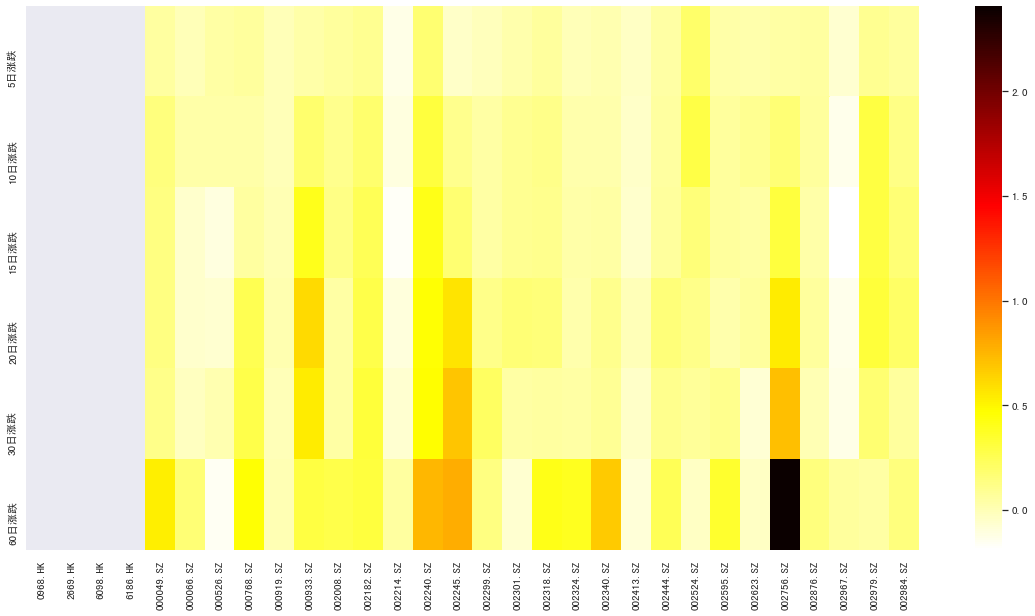

In [72]:
# 全部
sns.set(font="simhei")
f, ax = plt.subplots(figsize=(20, 10)) 
# sns.heatmap(stat_fund_portfolio_diff_result.iloc[: 30, :].loc[:, '5日涨跌' : '90日涨跌'].T, annot=False, ax=ax, cmap="hot_r")

sns.heatmap(stat_fund_portfolio_diff_result.iloc[: 30, :].loc[:, '5日涨跌' : '60日涨跌'].T, annot=False, ax=ax, cmap="hot_r")

##### 分组柱状图

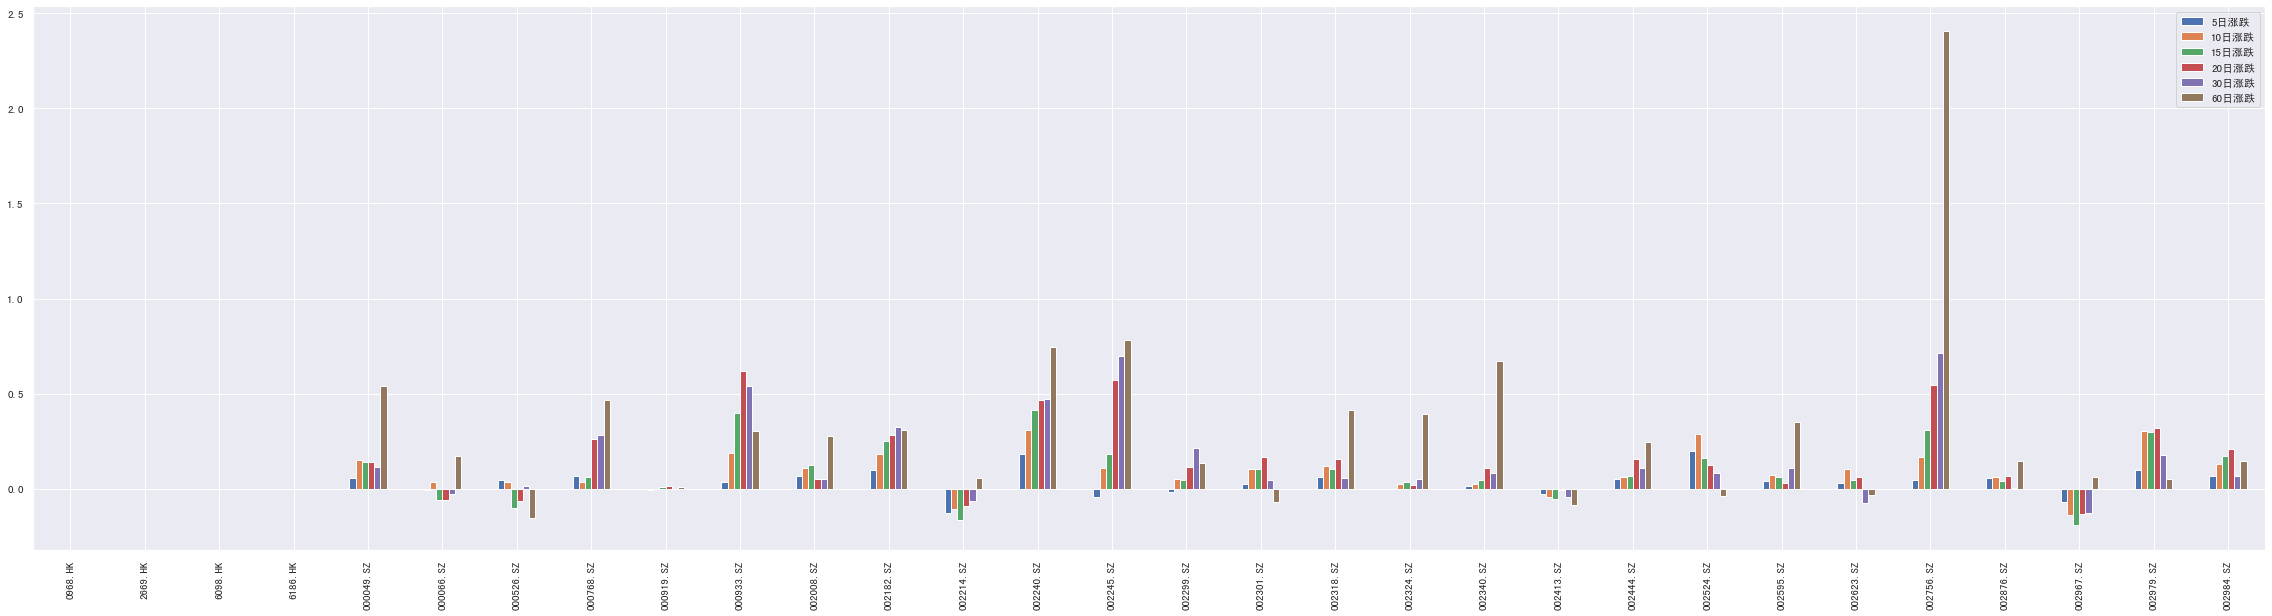

In [73]:
bar_df = stat_fund_portfolio_diff_result.iloc[: 30, :].loc[:, '5日涨跌' : '60日涨跌']
bar_df.plot(kind='bar', figsize=(40, 10))

plt.show()